In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch
from tqdm import tqdm

import pyro
from pyro.infer import SVI,Trace_ELBO
import pyro.distributions as dist

datapath =  '/'.join(os.getcwd().split("\\")[:-1])+"/0_Auxiliary_Tools/"

dataframe = pd.read_csv(datapath + "Unidi_Sample.csv",index_col=0)
data = []
longest=0
for i in dataframe["ID"]:
    timing_string = dataframe[dataframe["ID"]==i]["Observations"][0]
    timing_string = timing_string.split(" ")[1:-1]
    timing_string =[time.strip().strip('') for time in timing_string]
    timeseries = np.array([float(k) for k in list(filter(None,timing_string))])
    data.append(timeseries)
    longest = max(longest,len(timeseries))
    
'''
Use all the same code as before for the model
'''
class exp_kernel:
    def __init__(self,params):
        self.α = params[0]
        self.β = params[1]
    def density(self,t,history):
        history_deltas = (t.reshape(-1,1) - history)
        timing_mask = history_deltas>0
        raw = self.α*torch.exp(-self.β*(history_deltas*timing_mask))
        return torch.sum(raw*timing_mask,axis=1)   
    def cumulative(self,T,history):
        return torch.sum((self.α/self.β)*(1-torch.exp(-self.β*(T-history))))
    
class constant_baseline:
    def __init__(self,mu):
        self.mu = mu
    def density(self,t):
        return self.mu*torch.ones(t.reshape(-1,1).shape[0])
    def cumulative(self,T,t):
        return self.mu*T    

class Hawkes:
    def __init__(self,baseline,kernel,T):
        self.baseline = baseline
        self.kernel = kernel
        self.T = T
    def log_prob(self, t):
        safety = 1e-9
        h = self.baseline.density(t) + self.kernel.density(t,t)
        H = self.baseline.cumulative(self.T,t) + self.kernel.cumulative(self.T,t)
        ll = torch.sum(torch.log(safety + h)) - H
        return ll

# Variational Bayes

In the world of complicated Bayesian models, if we want accurate portrayals of (most of) the posterior distribution for our parameters, MCMC and associate methods are the best tools available. As we know, they are also very slow and temperamental on the best of days and with the best combination of starting priors and carefully engineered settings.

But we can still ask ourselves: can we sacrifice some of that richness and accuracy for estimation speed?

That's not only a matter of convenience. The usefulness of our models often relies on how easily they can be applied to industry settings, which - you know - use industry data, which for the most part comes in huge datasets.

A sophisticated compromise between speed and richness is offered by Variational Bayes techniques (Blei et al, 2017). Variational Inference attempts to estimate the posterior distribution indirectly by using approximations to the actual posterior that can be calculated much easier. A valid Variational approach may be to assume that the posterior distribution of each parameter is Normal and independent of other paramters. Given that assumption we can estimate the individual marginal Normal distributions that are closest to the actual posterior (which we never get to know).

And yes, it is as simple as ASSUMING something is Normal. That is the main shortcoming of this methodology. We can assume any distribution and the method will arrive at an estimate, independent of what the actual distribution we are approximating is. There are some methods to tell us if we have assumed something TERRIBLY far from the correct distribution (Yao et al, 2018), but once we are out of the realm of terrible, we can't get much more refinement. At the same time, while we have some proof that any non-terrible Variational Distribution is eventually going to converge to **a** center of mass of the actual posterior (a local optimum), we are also almost assured that we will severely underestimate posterior variance with any Variational Distribution (Giordano et al, 2015). So Variational p-values are worth absolutely nothing - ever. 

Nonetheless, if all you need are point estimates, p-values are of no concern, and you have a LOT of data, Variational Bayes is basically the best tool available. 

Back to the first question: HOW FAST IS IT? The progress bar below ran fairly fast.

And to that second pesky question: How bad do we perform? Below we can see the comparison of prior and posterior estimates (actual distributions in blue, estimated distributions in orange).

100%|██████████████████████████████████████████████████████████████████████████████| 8000/8000 [05:01<00:00, 26.54it/s]


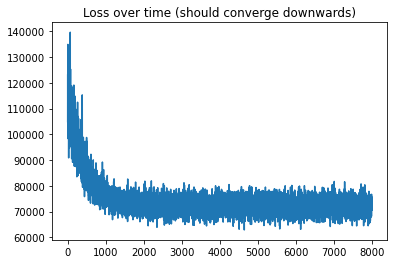

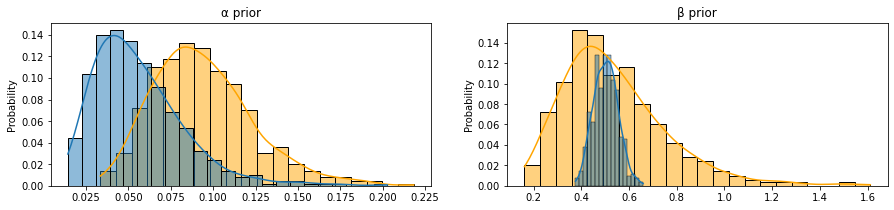

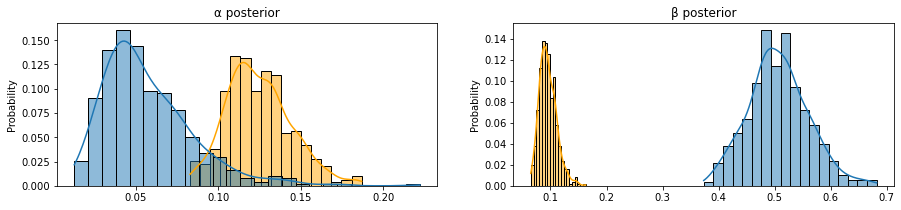

In [3]:
'''
Set the hierarchical structure with mixing dist and individidual parameters
''' 
def model(data,minibatch):
    # set starting values for hyperparameters
    hyperparams = pyro.sample("Hyperparameters", dist.Normal(torch.ones(6),torch.ones(6)).to_event(1))

    # draw individual params from mixing dists
    for i in pyro.plate("Obs",len(data)):
        μ = pyro.sample('μ_{}'.format(i),dist.Normal(hyperparams[0],torch.exp(hyperparams[1])))
        α = pyro.sample('α_{}'.format(i),dist.Normal(hyperparams[2],torch.exp(hyperparams[3])))
        β = pyro.sample('β_{}'.format(i),dist.Normal(hyperparams[4],torch.exp(hyperparams[5])))
        
        # the part where we actually compute the likelihood should only be in the model function 
        process = Hawkes(constant_baseline(torch.exp(μ)),exp_kernel([torch.exp(α),torch.exp(β)]),360)
        pyro.sample('Hawkes_{}'.format(i), process,obs=torch.tensor(data[i]))
        
'''
Define your posterior approximation!
'''
def guide(data,minibatch): # guide function must take the same args as model function
    # set the variational parameters to optimize
    vi_hyperparams = pyro.param("VI_Hyper", -torch.ones(12))
    vi_individual = pyro.param("VI_Individual", -torch.ones(len(data),6))
    
    # We must draw the hyperparameters and individual params from dists with the same support as before
    # For simplicity, let's use delta distributions (some deep learning tech)
    hyperparams = pyro.sample("Hyperparameters",dist.Normal(vi_hyperparams[:6],torch.exp(vi_hyperparams[6:])).to_event(1))    
    for i in pyro.plate("Obs",len(data),subsample_size= minibatch):
        μ = pyro.sample('μ_{}'.format(i),dist.Normal(vi_individual[i,0],torch.exp(vi_individual[i,1])))
        α = pyro.sample('α_{}'.format(i),dist.Normal(vi_individual[i,2],torch.exp(vi_individual[i,3])))
        β = pyro.sample('β_{}'.format(i),dist.Normal(vi_individual[i,4],torch.exp(vi_individual[i,5])))

'''
Configure the SVI estimator
'''
pyro.clear_param_store() # make sure your memory is clean
n_steps = 8000  # set number of steps for optimization
minibatch = 3 # how many individuals to use for each optimization step
elbo = Trace_ELBO(num_particles=3) # set method for estimating quality of approximation
optim = pyro.optim.Adam({"lr":1e-2}) # call a fancy solver and tell it how fast it should update
svi = SVI(model, guide, optim, loss=elbo) # compile the full estimator 
    
'''
Actually run it
'''
losses = [] # track shittiness over time
for step in tqdm(range(n_steps)):
    new = svi.step(data,minibatch)
    losses.append(new)
# check out if the model converged
plt.plot(losses)
plt.title("Loss over time (should converge downwards)")
plt.show()

# save estimated params in a single dictionary 
# it's good to have everything in a single place in case we want to set a checkpoint
posterior_params = {k: np.array(v.data) for k, v in pyro.get_param_store().items()}


'''
Plot mixing distribution
'''
hyperparameters= torch.tensor(posterior_params['VI_Hyper'])
estimated_a = dist.Normal(hyperparameters[2],torch.exp(hyperparameters[3])).sample([500])
estimated_b = dist.Normal(hyperparameters[4],torch.exp(hyperparameters[5])).sample([500])

actual_hyperparams = [0.05,0.5,0.5,0.1]
actual_alpha_dist = np.exp(np.random.normal(np.log(actual_hyperparams[0]),actual_hyperparams[1],500))
actual_beta_dist = np.exp(np.random.normal(np.log(actual_hyperparams[2]),actual_hyperparams[3],500))

fig, axes = plt.subplots(1, 2,figsize=(15,3))
sns.histplot(torch.exp(estimated_a), ax=axes[0],kde=True,stat="probability",color = "orange")
sns.histplot(actual_alpha_dist, ax=axes[0],kde=True,stat="probability")
axes[0].set_title("α prior")
sns.histplot(torch.exp(estimated_b), ax=axes[1],kde=True,stat="probability",color = "orange")
sns.histplot(actual_beta_dist, ax=axes[1],kde=True,stat="probability")
axes[1].set_title("β prior")
plt.show()


'''
Check accuracy of individual posteriors
'''
actual_a = []
actual_b = []
for i in dataframe["ID"]:
    actual_params= dataframe[dataframe["ID"]==i]["Params"][0]
    actual_params=actual_params.strip('[').strip(']').split(",")
    actual_a.append(float(actual_params[0]))
    actual_b.append(float(actual_params[1]))
actual_a = torch.tensor(actual_a)
actual_b = torch.tensor(actual_b)

estimated_a = np.exp(posterior_params["VI_Individual"][:,1])
estimated_b = np.exp(posterior_params["VI_Individual"][:,2])

fig, axes = plt.subplots(1, 2,figsize=(15,3))
sns.histplot(estimated_a, ax=axes[0],kde=True,stat="probability",color = "orange")
sns.histplot(actual_a, ax=axes[0],kde=True,stat="probability")
axes[0].set_title("α posterior")
sns.histplot(estimated_b, ax=axes[1],kde=True,stat="probability",color = "orange")
sns.histplot(actual_b, ax=axes[1],kde=True,stat="probability")
axes[1].set_title("β posterior")
plt.show()

These are not unreasonable. There are other tricks we can use to go from not unreasonable to fairly sound. But first, can we get even faster? Yes. 

The core idea for the next step is to get rid of all for-loops by reformatting the entire dataset as a single I by K matrix, where I is the number of processes (500) and K is the largest number of observations per process. This has nothing to do with complex theoretical math and is entirely based on how computers actually perform sequences of operations. If we can turn the process of computing multiple sequential likelihoods into a set of operations on a single large matrix, we can get fairly faster.

We can even go one step further by distributing sampling steps through parallel computing strategies, possibly powered by a convenient gaming GPU (although for this notebook everything is done in CPU).

# Parallelization tricks

Here is the model reformatted to run in parallel. Does it look confusing? It should! I spent my last weekend figuring this out.

In [4]:
re_data = []
for i in range(len(data)):
    re_data.append(np.pad(data[i],(0,longest-len(data[i]))))
re_data = torch.tensor(np.array(re_data))
print("Padded dataset shape: ",re_data.shape)

class p_constant_baseline:
    def __init__(self,mu):
        self.mu = mu.reshape(-1,1)
    def density(self,t):
        mask = t>0
        return self.mu*torch.ones(t.shape)
    def cumulative(self,t):
        return self.mu*torch.ones([t.shape[0],1])*360
    
class p_exp_kernel:
    def __init__(self,α,β):
        self.α = α.reshape(-1,1,1)
        self.β = β.reshape(-1,1,1)
    def density(self,t):
        t = t.reshape(t.shape[0],t.shape[1],1)
        padding_mask = t>0
        raw_deltas = t - torch.transpose(t,2,1)
        timing_mask = raw_deltas>0
        f_deltas = torch.multiply(self.α,torch.exp(torch.multiply(-self.β,raw_deltas)))
        masked_delta = torch.multiply(padding_mask,torch.multiply(f_deltas,timing_mask))
        density = torch.sum(masked_delta,axis=1)
        return density
    def cumulative(self,t):
        T = 360*torch.ones([t.shape[0],1])
        actual_entries = t>0
        raw_deltas = T - t
        cumul_interval = (1 - torch.exp(torch.multiply(-self.β.reshape(-1,1),raw_deltas)))
        scale = torch.multiply(self.α,1/self.β)
        f_deltas = torch.multiply(scale.reshape(-1,1),cumul_interval)
        masked_delta = torch.multiply(f_deltas,actual_entries)
        cumulative = torch.sum(masked_delta,axis=1)
        return cumulative.reshape(-1,1)    
    
class p_Hawkes():
    def __init__(self,baseline,kernel):
        self.baseline = baseline
        self.kernel = kernel
    def log_prob(self, t):
        mask = t>0
        h = self.baseline.density(t) + self.kernel.density(t)
        H = self.baseline.cumulative(t) + self.kernel.cumulative(t)
        ll = torch.sum(torch.log(1e-10+h)*mask,1) - torch.sum(H,1)
        return ll
    
def model(data):
    hyperparams = pyro.sample("Hyperparameters", dist.Normal(torch.ones(6),torch.ones(6)).to_event(1))
    with pyro.plate("Individual",len(data)):
        μ = pyro.sample('μ',dist.Normal(hyperparams[0],torch.exp(hyperparams[1])))
        α = pyro.sample('α',dist.Normal(hyperparams[2],torch.exp(hyperparams[3])))
        β = pyro.sample('β',dist.Normal(hyperparams[4],torch.exp(hyperparams[5])))
    with pyro.plate("Obs",len(data)) as idx:
        baseline = p_constant_baseline(torch.exp(μ))
        kernel = p_exp_kernel(torch.exp(α),torch.exp(β))
        process = p_Hawkes(baseline,kernel)
        pyro.sample('Hawkes', process, obs=data)
        
def guide(data):
    vi_hyperparams = pyro.param("VI_Hyper", -1*torch.ones(12))
    vi_individual = pyro.param("VI_Individual", -2*torch.ones(len(data),6))
    hyperparams = pyro.sample("Hyperparameters",dist.Normal(vi_hyperparams[:6],torch.exp(vi_hyperparams[6:])).to_event(1))
    with pyro.plate("Individual",len(data)):
        μ = pyro.sample('μ',dist.Normal(vi_individual[:,0],torch.exp(vi_individual[:,1])))
        α = pyro.sample('α',dist.Normal(vi_individual[:,2],torch.exp(vi_individual[:,3])))
        β = pyro.sample('β',dist.Normal(vi_individual[:,4],torch.exp(vi_individual[:,5])))

Padded dataset shape:  torch.Size([500, 82])


Cool. So how fast can we actually make this? Since we aren't subsampling, we don't need to take as many steps to get to more or less the same answer.

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:53<00:00,  8.83it/s]


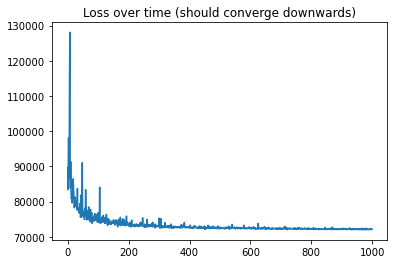

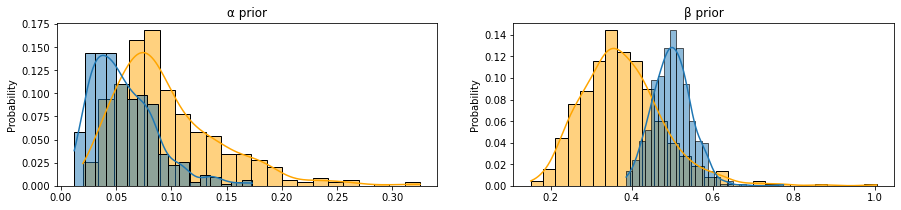

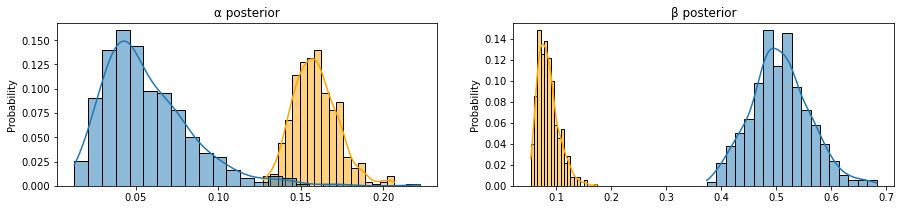

In [5]:
'''
Configure the SVI estimator
'''
pyro.clear_param_store()
n_steps = 1000
elbo = Trace_ELBO(num_particles=1) 
optim = pyro.optim.Adam({"lr":1e-2})
svi = SVI(model, guide, optim, loss=elbo) 

losses = [] 
for step in tqdm(range(n_steps)):
    new = svi.step(re_data)
    losses.append(new)
plt.plot(losses)
plt.title("Loss over time (should converge downwards)")
plt.show()

posterior_params = {k: np.array(v.data) for k, v in pyro.get_param_store().items()}

'''
Plot mixing distribution
'''
hyperparameters= torch.tensor(posterior_params['VI_Hyper'])
estimated_a = dist.Normal(hyperparameters[2],torch.exp(hyperparameters[3])).sample([500])
estimated_b = dist.Normal(hyperparameters[4],torch.exp(hyperparameters[5])).sample([500])

actual_hyperparams = [0.05,0.5,0.5,0.1]
actual_alpha_dist = np.exp(np.random.normal(np.log(actual_hyperparams[0]),actual_hyperparams[1],500))
actual_beta_dist = np.exp(np.random.normal(np.log(actual_hyperparams[2]),actual_hyperparams[3],500))

fig, axes = plt.subplots(1, 2,figsize=(15,3))
sns.histplot(torch.exp(estimated_a), ax=axes[0],kde=True,stat="probability",color = "orange")
sns.histplot(actual_alpha_dist, ax=axes[0],kde=True,stat="probability")
axes[0].set_title("α prior")
sns.histplot(torch.exp(estimated_b), ax=axes[1],kde=True,stat="probability",color = "orange")
sns.histplot(actual_beta_dist, ax=axes[1],kde=True,stat="probability")
axes[1].set_title("β prior")
plt.show()

'''
Check accuracy of individual posteriors
'''
actual_a = []
actual_b = []
for i in dataframe["ID"]:
    actual_params= dataframe[dataframe["ID"]==i]["Params"][0]
    actual_params=actual_params.strip('[').strip(']').split(",")
    actual_a.append(float(actual_params[0]))
    actual_b.append(float(actual_params[1]))
actual_a = torch.tensor(actual_a)
actual_b = torch.tensor(actual_b)

estimated_a = np.exp(posterior_params["VI_Individual"][:,1])
estimated_b = np.exp(posterior_params["VI_Individual"][:,2])

fig, axes = plt.subplots(1, 2,figsize=(15,3))
sns.histplot(estimated_a, ax=axes[0],kde=True,stat="probability",color = "orange")
sns.histplot(actual_a, ax=axes[0],kde=True,stat="probability")
axes[0].set_title("α posterior")
sns.histplot(estimated_b, ax=axes[1],kde=True,stat="probability",color = "orange")
sns.histplot(actual_b, ax=axes[1],kde=True,stat="probability")
axes[1].set_title("β posterior")
plt.show()

Our results are surprisingly different than before. A good deal of that is that we are not subsampling anymore. Without that, we get essentially the same means as before, but with narrower bounds. Another culprit is that the other estimation settings, including starting values, are slightly different as well. 

# Bibliography

Blei, David M., Alp Kucukelbir, and Jon D. McAuliffe. “Variational Inference: A Review for Statisticians.” Journal of the American Statistical Association 112, no. 518 (April 3, 2017): 859–77. https://doi.org/10.1080/01621459.2017.1285773.

Giordano, Ryan, Tamara Broderick, and Michael I. Jordan. “Covariances, Robustness, and Variational Bayes.” arXiv, October 17, 2018. https://doi.org/10.48550/arXiv.1709.02536.

Yao, Y., Vehtari, A., Simpson, D., & Gelman, A. (2018). Yes, but Did It Work?: Evaluating Variational Inference (arXiv:1802.02538). arXiv. https://doi.org/10.48550/arXiv.1802.02538
